### Imports and Setup

In [10]:
# Imports
from IPython.display import display
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sympy.physics.vector import dynamicsymbols
from sympy import symbols, cos, sin, diff, sqrt, init_printing, latex, Symbol, Eq, solve, lambdify, print_latex, simplify, cse
from scipy.integrate import solve_ivp
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.optimize import minimize

params = {
    "animation.html": "jshtml",
    "ytick.color" : "black",
    "xtick.color" : "black",
    "axes.labelcolor" : "black",
    "axes.edgecolor" : "black",
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : ["Computer Modern Serif"],
    "font.size": 14
}
plt.rcParams.update(params)

# Make printouts look nicer
latexReplaceRules = {
    r'{\left(t \right)}':r' ',
    r'\frac{d}{d t}':r'\dot',
    r'\frac{d^{2}}{d t^{2}}':r'\ddot',
}

def latexNew(expr,**kwargs):
    retStr = latex(expr,**kwargs)
    for _,__ in latexReplaceRules.items():
        retStr = retStr.replace(_,__)
    return retStr

init_printing(latex_printer=latexNew)

def pprint_eqn(**kwargs):
    name = list(kwargs.keys())[0]
    return Eq(Symbol(name), kwargs[name], evaluate=False)

/var/folders/b1/15j_gfbn6q1b0txsrcxn2zrw0000gn/T/ipykernel_33889/1044316109.py:10: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
/var/folders/b1/15j_gfbn6q1b0txsrcxn2zrw0000gn/T/ipykernel_33889/1044316109.py:11: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
/var/folders/b1/15j_gfbn6q1b0txsrcxn2zrw0000gn/T/ipykernel_33889/1044316109.py:11: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion


Define constants used in the problem

In [2]:
G, M, omega, m, m0, f, a, d, e, tau = symbols(r"G, M, \Omega, m_\oplus, m_0, f, a, d, e \tau", real=True, positive=True)

t=Symbol('t')

Define dynamic variables used in the problem and the Lagrangian

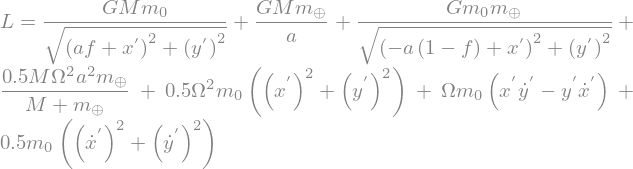

In [3]:
x, y = dynamicsymbols("x^', y^'", real=True)
x_dot = x.diff()
y_dot = y.diff()

L = (1/2) * (M*m)/(M+m) * a**2 * omega**2 + (1/2)*m0*(x_dot**2 + y_dot**2) + (1/2)*m0*omega**2*(x**2+y**2) + m0*omega *(x*y_dot - x_dot*y) + (G*M*m)/a + (G*M*m0)/(sqrt((x+f*a)**2 + y**2)) + (G*m*m0)/(sqrt((x-(1-f)*a)**2 + y**2))
pprint_eqn(L=L)

Euler Lagrange Equation for x


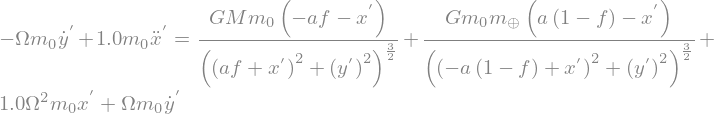

Euler Lagrange Equation for y


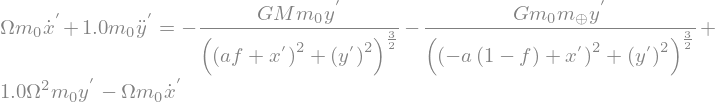

In [4]:
x_derivative = L.diff(x)
x_dot_derivative = L.diff(x_dot) #same as what Prof Tamayo gets!
x_dot_second_derivative = x_dot_derivative.diff(t)

# Euler-Lagrange Equation for x 
ELx = Eq(x_dot_second_derivative, x_derivative)
print("Euler Lagrange Equation for x")
display(ELx)

y_derivative = L.diff(y)
y_dot_derivative = L.diff(y_dot) #same as what Prof Tamayo gets!
y_dot_second_derivative = y_dot_derivative.diff(t)

# Euler-Lagrange Equation for y
ELy = Eq(y_dot_second_derivative, y_derivative)
print("Euler Lagrange Equation for y")
display(ELy)

Equations of motion


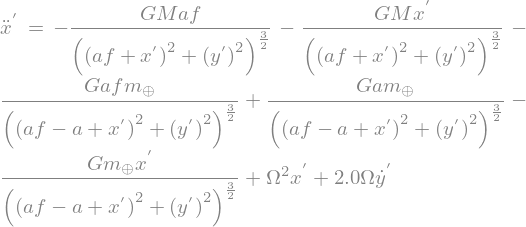

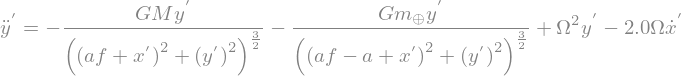

In [5]:
# Isolating x & y double dot
x_doubledot= solve(ELx, x_dot.diff(t))[0] 
y_doubledot= solve(ELy, y_dot.diff(t))[0]

print("Equations of motion")
display(Eq(x_dot.diff(t), x_doubledot))
display(Eq(y_dot.diff(t), y_doubledot))

Now we non-dimensionalize the equations of motion by substituting:
- $x' = X'a$ and $y' = Y'a$
- $\tau = t\Omega$
- $\displaystyle d = \frac{Gm_\oplus}{\Omega^2a^3}$
- $\displaystyle e = \frac{GM}{\Omega^2a^3}$
- $\displaystyle f = \frac{m_\oplus}{M+m_\oplus}$

Equations of motion


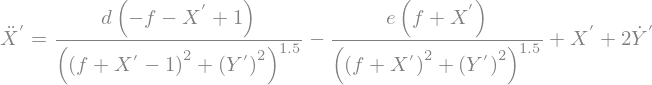

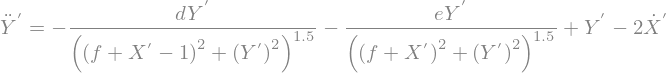

In [6]:
# nondimensionalization
X, Y = dynamicsymbols("X^', Y^'", real=True)
X_dot = X.diff()
Y_dot = Y.diff()

X_doubledot=2*Y.diff() + X +d*(1-X-f)/((f-1+X)**2 +Y**2)**(3/2) -e*(X+f)/((f+X)**2+Y**2)**(3/2)
Y_doubledot=-2*X.diff() + Y -d*Y/((f-1+X)**2 +Y**2)**(3/2) -e*(Y)/((f+X)**2+Y**2)**(3/2)

print("Equations of motion")
display(Eq(X_dot.diff(t), X_doubledot))
display(Eq(Y_dot.diff(t), Y_doubledot))

d_calc = lambda G,m,omega,a: G*m/(omega**2*a**3)
e_calc = lambda G,M,omega,a: G*M/(omega**2*a**3)
f_calc = lambda M,m: m/(M+m)

We can also define the non-dimensionalized hamiltonian as

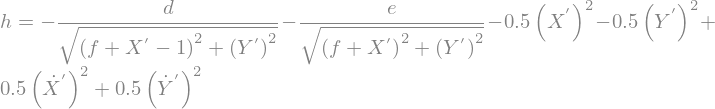

In [7]:
#this is for the nondimensionalized hamiltonian h

h=0.5*(X_dot**2 +Y_dot**2) -0.5*(X**2+Y**2) -e/sqrt((X+f)**2+Y**2) -d/sqrt((X-(1-f))**2+Y**2)

pprint_eqn(h=h)

For future use, we will want to be able to recover the true system parameters from the non-dimensionalized quantities

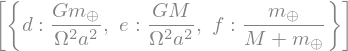

In [8]:
# solve([Eq(f, M/(M+m)), Eq(d, G*m/(omega*a)**2), Eq(e, G*M/(omega*a)**2)])
solve([Eq(f, m/(M+m)), Eq(d, G*m/(omega*a)**2), Eq(e, G*M/(omega*a)**2)], implicit=True, manual=True)

In [9]:
# lambdify, give eq in terms of variables, gives its inputs, then lets you input the inputs in the expression. So turn symbolic math into python function 

gx = lambdify((X, Y, Y_dot, d, e, f), X_doubledot, 'numpy') #Before, python solved for X dot dot and Y dot dot. So, this puts that as a function, so we can use it later for our DE. 
fy = lambdify([X, X_dot, Y, d, e, f], Y_doubledot, 'numpy')

H = lambdify([X, X_dot, Y, Y_dot, d, e, f], h, 'numpy') #took away m0 bc not hamiltonian...

def three_body_prob(tau, Z, d, e, f): #Not sure why we need it, but I added tau back in.
    X, w, Y, z = Z #separates Z into 4 variables, corresponding to X, X dot, Y, Y dot. So...I guess Z is supposed to be a list? 

    X_dot = w
    Y_dot = z
    w_dot = gx(X, Y, Y_dot, d, e, f)
    z_dot = fy(X, X_dot, Y, d, e, f)

    return X_dot, w_dot, Y_dot, z_dot

def get_solution(diffeq, initial_conditions, tstart=None, tend=None, pts=1000, t=None, **kwargs):
    if t is None:
        t = np.linspace(tstart, tend, int(pts))

    # return odeint(diffeq, initial_conditions, t, args=params, **kwargs).T
    return solve_ivp(diffeq, (np.min(t), np.max(t)), initial_conditions, t_eval=t, **kwargs)

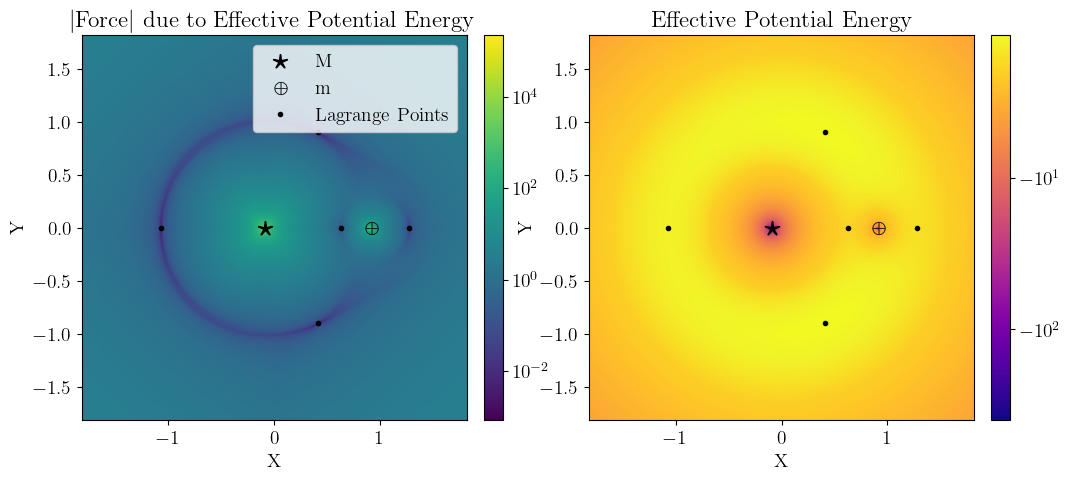

Lagrange Points
[[ 4.09090909e-01 -9.03106991e-01]
 [-1.06958783e+00 -2.74016268e-11]
 [ 6.30662890e-01 -6.85428581e-12]
 [ 1.27634754e+00  3.00952071e-11]
 [ 4.09090909e-01  9.03106991e-01]]


In [42]:
omega_=1
g_=1
a_=1
m_=0.1
M_=1
args = (d_calc(g_,m_,omega_,a_), e_calc(g_,M_,omega_,a_), f_calc(M_,m_)) #this is just d, e, f, so we can insert this into three_body_prob. 
M_pos = -a_*(args[2])
m_pos = a_*(1-args[2])

x_force = X_doubledot.subs(((X_dot, 0), (Y_dot, 0)))
y_force = Y_doubledot.subs(((X_dot, 0), (Y_dot, 0)))
force = lambdify([X, Y, d, e, f], abs(x_force)+abs(y_force))
potential = lambdify([X, Y, d, e, f], h.subs(((X_dot, 0), (Y_dot, 0))))

def detect_peaks(image, size=20):
    # Modified from: https://stackoverflow.com/a/3689710
    local_max = maximum_filter(image, size=100)==image

    background = (image==0)

    eroded_background = binary_erosion(background, structure=generate_binary_structure(2, 2), border_value=1)

    detected_peaks = local_max ^ eroded_background

    return detected_peaks

x, y = np.meshgrid(np.linspace(-2*m_pos,2*m_pos,1000), np.linspace(-2*m_pos,2*m_pos,1000))
potential_eval = potential(x, y, *args)
force_eval = force(x, y, *args)

# Find approximate location of lagrange points from 2d scan
minima = detect_peaks(-force_eval)
lagrange_points_idx = np.argwhere(minima)
lagrange_points = np.stack((x[0,lagrange_points_idx[:,1]], y[lagrange_points_idx[:,0],0]))


# Find exact location of lagrange points by minimizing the force function
fixed_lagrange_points = []
for p in lagrange_points.T:
    fixed_lagrange_points.append(minimize(lambda z: force(*z, *args), p, tol=1e-10, method='Nelder-Mead').x)
lagrange_points = np.array(fixed_lagrange_points).T

fig, axs = plt.subplots(1, 2, figsize=(12,5))

for ax in axs:
    ax.scatter(M_pos, 0, label="M", c='black', zorder=10, marker="$\\star$", s=100, linewidth=1)
    ax.scatter(m_pos, 0, label="m", c='black', zorder=10, marker="$\\oplus$", s=100, linewidth=0.2)
    ax.plot(lagrange_points[0], lagrange_points[1], label='Lagrange Points', c='black', marker=".", linestyle='')

c = axs[0].pcolormesh(x, y, force_eval, norm='log', cmap='viridis', shading='gouraud', rasterized=True)
plt.colorbar(c, ax=axs[0], fraction=0.046, pad=0.04)
axs[0].legend()
axs[0].set_aspect(1)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("$|$Force$|$ due to Effective Potential Energy")

c = axs[1].pcolormesh(x, y, potential_eval, norm='symlog', cmap='plasma', shading='gouraud', rasterized=True)
plt.colorbar(c, ax=axs[1], fraction=0.046, pad=0.04)

axs[1].set_title("Effective Potential Energy")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_aspect(1)

plt.savefig('figures/lagrange_points.pdf')

plt.show()

print("Lagrange Points")
print(lagrange_points.T)

### Exploration

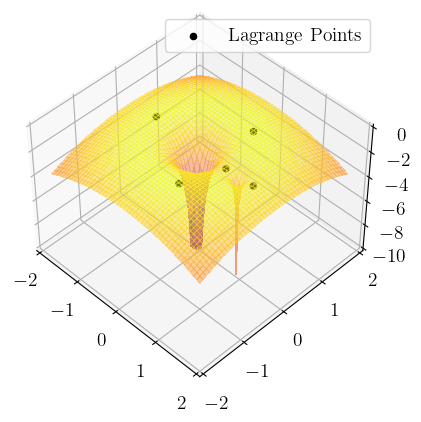

In [43]:
fig = plt.figure(1)
ax = fig.add_subplot(projection='3d')

# Plot the surface.
lim = -10
pts = ax.scatter(lagrange_points[0], lagrange_points[1], potential(lagrange_points[0], lagrange_points[1], *args)+0.1, c='black', marker='o', alpha=1, zorder=10, label="Lagrange Points")
surf = ax.plot_surface(x, y, np.maximum(lim, potential_eval), linewidth=0, antialiased=False, alpha=0.5, cmap='plasma', zorder=-1)
ax.legend()
ax.set_zlim(lim, 0)
ax.view_init(azim=-45, elev=45)


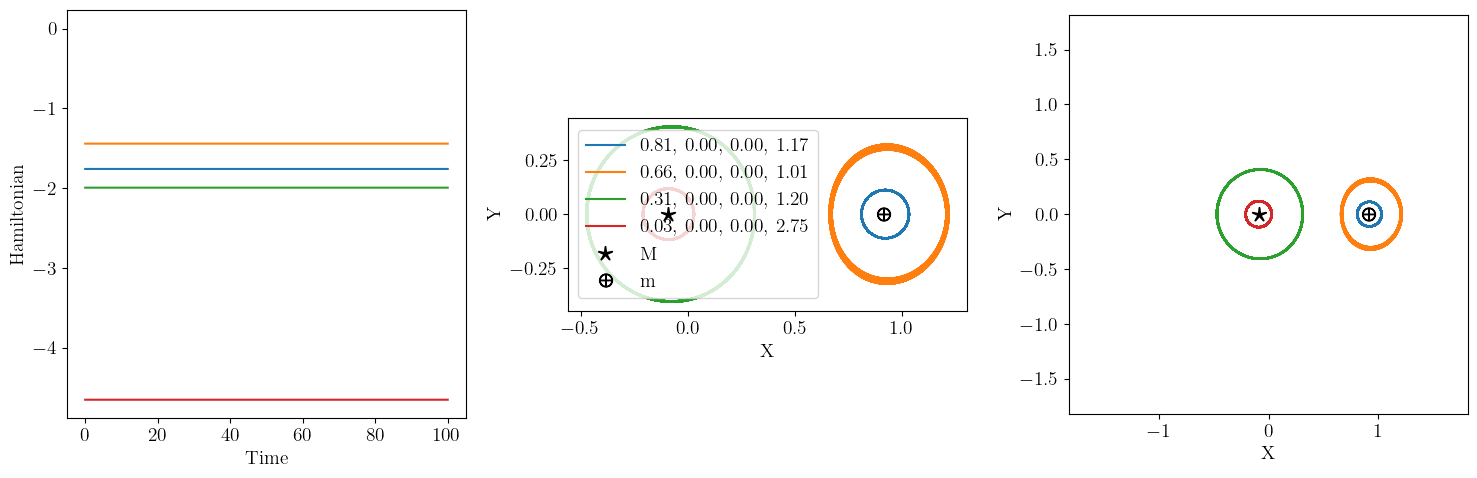

In [22]:
#solving the differential equation
fig, axs = plt.subplots(1, 3, figsize=(15,5))

initial_conditions = [
    # simple orbits
    (m_pos - 0.1, 0, 0, 1.165), # earth small
    (m_pos - 0.25, 0, 0, 1.008), # earth large
    (M_pos + 0.4, 0, 0, 1.2), # sun large
    (M_pos + 0.12, 0, 0, 2.755), # sun small
    # testing boundary between sun and earth
    # (0.6, 0, 0, 0), # bounday is at 0.630665
    # (0.7, 0, 0, 0),
    # chaotic orbit
    # (0, 0, m_pos*1.01, 0),
    # (M_pos + 0.4, 0, 0, 1.5),
    # (m_pos - 0.3, 0, 0, 0.2)
] # X initial, X dot initial, Y initial, Y dot initial

for ic in initial_conditions:
    sol = get_solution(lambda tau, Z: three_body_prob(tau, Z, *args), ic, tstart=0, tend=100, pts=10000, rtol=1e-8, atol=1e-8)
    xa, wa, ya, za = sol.y
    t_eval = sol.t

    axs[0].plot(t_eval, H(xa, wa, ya, za, *args))
    axs[1].plot(xa, ya, label=f"{ic[0]:.2f}, {ic[1]:.2f}, {ic[2]:.2f}, {ic[3]:.2f}")
    axs[2].plot(xa, ya)

axs[0].scatter(0,0, c='white') # force x = 0 to be included
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Hamiltonian")

axs[1].plot(M_pos, 0, label="M", c='black', zorder=10, marker="$\\star$", markersize=10, linestyle='')
axs[1].plot(m_pos, 0, label="m", c='black', zorder=10, marker="$\\oplus$", markersize=10, linestyle='')
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_aspect(1)
axs[1].legend()

axs[2].plot(M_pos, 0, label="M", c='black', zorder=10, marker="$\\star$", markersize=10, linestyle='')
axs[2].plot(m_pos, 0, label="m", c='black', zorder=10, marker="$\\oplus$", markersize=10, linestyle='')
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
axs[2].set_aspect(1)
bndry = 2*m_pos
axs[2].set_xlim(-bndry, bndry)
axs[2].set_ylim(-bndry, bndry)

fig.tight_layout()
plt.show()

To generate surfaces of section, we need to pick a degree of freedom and value to slice along, we have chose $Y=0$ because that is when the mass $m_0$ crosses the line formed by $M$ and $m_\oplus$

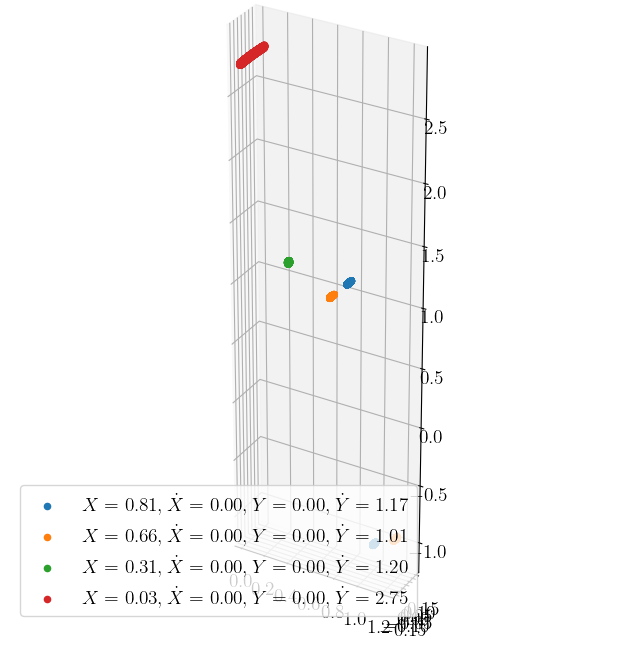

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

for i, ic in enumerate(initial_conditions):
    sol = get_solution(lambda tau, Z: three_body_prob(tau, Z, *args), ic, tstart=0, tend=1000, pts=200000, rtol=1e-8, atol=1e-8)
    xa, wa, ya, za = sol.y
    t_eval = sol.t

    idxs = []
    chk = -np.abs(ya)
    for i in range(1, len(ya)-1):
        if (chk[i - 1] < chk[i] > chk[i + 1]) and chk[i] > -0.01 and xa[i] > 0:
            idxs.append(i)

    ax.scatter(
        xa[idxs],
        wa[idxs],
        za[idxs],
        label=f'$X={ic[0]:.2f}, \\dot X={ic[1]:.2f}, Y={ic[2]:.2f}, \\dot Y={ic[3]:.2f}$',
        # alpha=0.1
    )

ax.legend()
ax.set_aspect('equal')
plt.show()

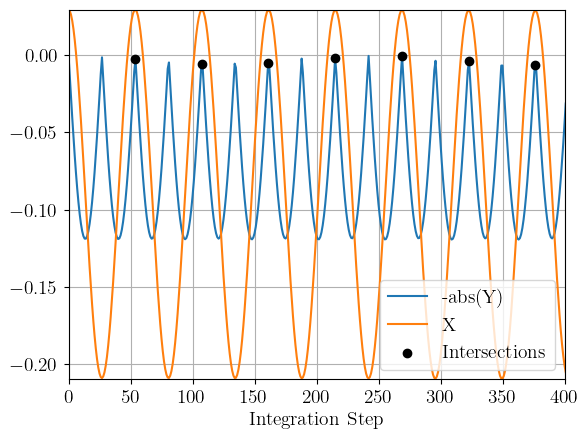

In [24]:
fig, ax = plt.subplots()
ax.margins(0)
ax.plot(chk, label='-abs(Y)')
# plt.scatter(0,0.01, c='w') # make axes look nice
ax.plot(xa, label='X')
ax.set_xlim(0, 400)
plt.scatter(idxs, chk[idxs], c='black', zorder=10, label='Intersections')
# ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), (xa[np.newaxis] > 0) * 1, cmap='RdYlGn', alpha=0.3)
plt.legend()
plt.xlabel("Integration Step")
plt.grid()
plt.savefig("figures/intersection_calculation.pdf")
plt.show()

### Nice Figures for Report

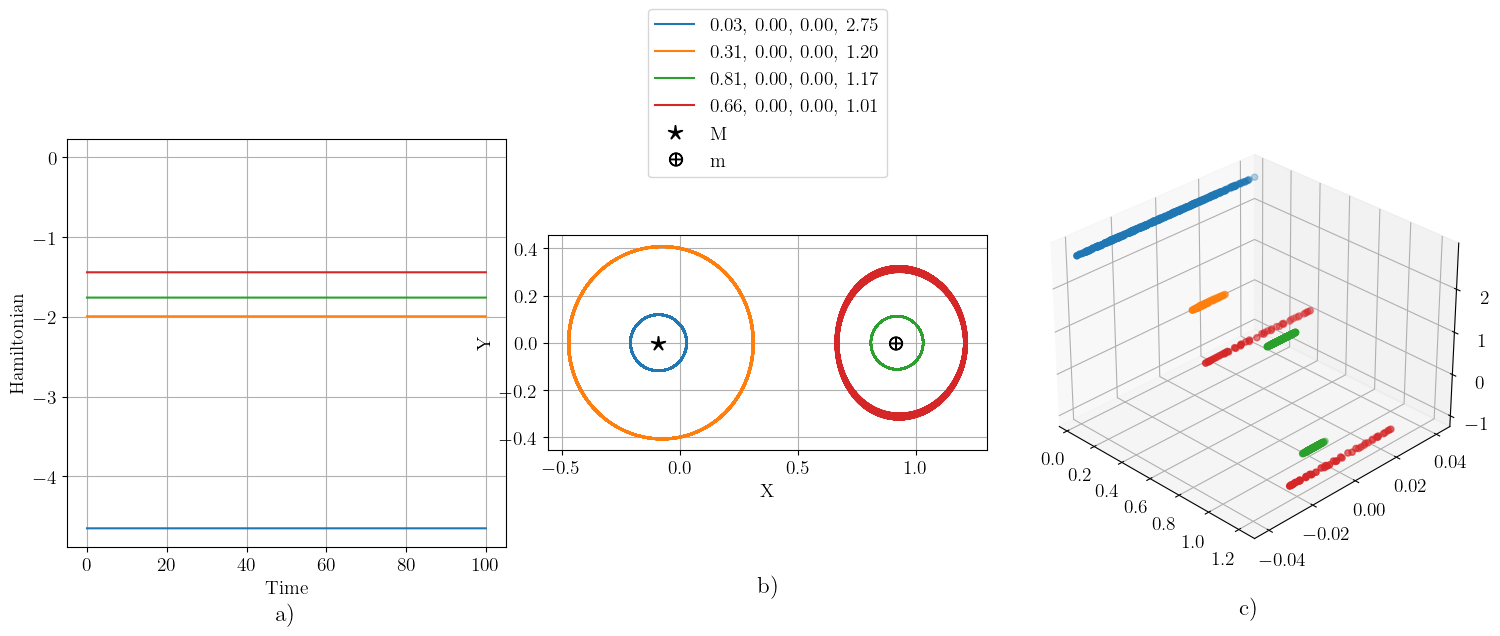

In [25]:
fig = plt.figure(figsize=(15,10))
axs = [fig.add_subplot(1,3,1),fig.add_subplot(1,3,2),fig.add_subplot(1,3,3, projection='3d')]

initial_conditions = [
    (M_pos + 0.12, 0, 0, 2.755), # sun small
    (M_pos + 0.4, 0, 0, 1.2), # sun large
    (m_pos - 0.1, 0, 0, 1.165), # earth small
    (m_pos - 0.25, 0, 0, 1.008), # earth large
] # X initial, X dot initial, Y initial, Y dot initial

for ic in initial_conditions:
    sol = get_solution(lambda tau, Z: three_body_prob(tau, Z, *args), ic, tstart=0, tend=100, pts=100000, rtol=1e-8, atol=1e-8)
    xa, wa, ya, za = sol.y
    t_eval = sol.t

    axs[0].plot(t_eval, H(xa, wa, ya, za, *args))
    axs[1].plot(xa, ya, label=f"{ic[0]:.2f}, {ic[1]:.2f}, {ic[2]:.2f}, {ic[3]:.2f}")

    idxs = []
    chk = -np.abs(ya)
    for i in range(1, len(ya)-1):
        if (chk[i - 1] < chk[i] > chk[i + 1]) and chk[i] > -0.01 and xa[i] > 0:
            idxs.append(i)

    axs[2].scatter(
        xa[idxs],
        wa[idxs],
        za[idxs],
        label=f'$X={ic[0]:.2f}, \\dot X={ic[1]:.2f}, Y={ic[2]:.2f}, \\dot Y={ic[3]:.2f}$',
        # alpha=0.1
    )

axs[0].scatter(0,0, c='white') # force x = 0 to be included
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Hamiltonian")
axs[0].set_aspect(20)
axs[0].set_title("a)", y=-0.2)
axs[0].grid()

axs[1].plot(M_pos, 0, label="M", c='black', zorder=10, marker="$\\star$", markersize=10, linestyle='')
axs[1].plot(m_pos, 0, label="m", c='black', zorder=10, marker="$\\oplus$", markersize=10, linestyle='')
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_aspect(1)
bndry = 0.5*m_pos
# axs[1].set_xlim(-bndry, bndry)
axs[1].set_ylim(-bndry, bndry)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 2.1))
axs[1].set_title("b)", y=-0.7)
axs[1].grid()

axs[2].view_init(azim=-45, elev=30)
axs[2].set_title("c)", y=-0.15)

fig.tight_layout(w_pad=-2)

plt.savefig("figures/circular_orbits.pdf")

plt.show()

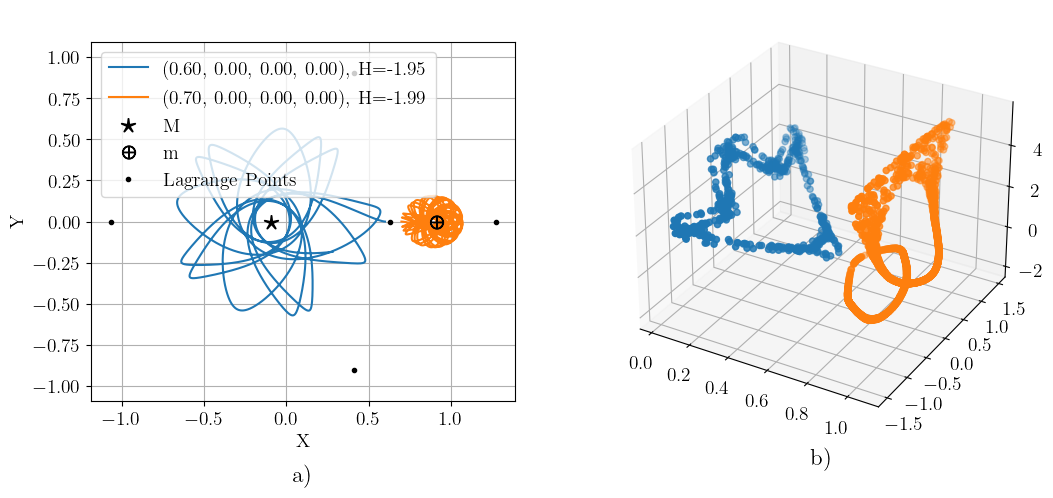

In [44]:
fig = plt.figure(figsize=(15,5))
axs = [fig.add_subplot(1,3,2),fig.add_subplot(1,3,3, projection='3d')]

initial_conditions = [
    (0.6, 0, 0, 0), # bounday is at 0.630665
    (0.7, 0, 0, 0),
] # X initial, X dot initial, Y initial, Y dot initial

for ic in initial_conditions:
    sol = get_solution(lambda tau, Z: three_body_prob(tau, Z, *args), ic, tstart=0, tend=1000, pts=1000000, rtol=1e-8, atol=1e-8)
    xa, wa, ya, za = sol.y
    t_eval = sol.t

    line_idxs = t_eval < 20
    traj_h = np.mean(H(xa, wa, ya, za, *args))
    axs[0].plot(xa[line_idxs], ya[line_idxs], label=f"({ic[0]:.2f}, {ic[1]:.2f}, {ic[2]:.2f}, {ic[3]:.2f}), H={traj_h:.2f}")

    idxs = []
    chk = -np.abs(ya)
    for i in range(1, len(ya)-1):
        if (chk[i - 1] < chk[i] > chk[i + 1]) and chk[i] > -0.01 and xa[i] > 0:
            idxs.append(i)
    
    axs[1].scatter(
        xa[idxs],
        wa[idxs],
        za[idxs],
        label=f'$X={ic[0]:.2f}, \\dot X={ic[1]:.2f}, Y={ic[2]:.2f}, \\dot Y={ic[3]:.2f}$',
        # alpha=0.1
    )

axs[0].plot(M_pos, 0, label="M", c='black', zorder=10, marker="$\\star$", markersize=10, linestyle='')
axs[0].plot(m_pos, 0, label="m", c='black', zorder=10, marker="$\\oplus$", markersize=10, linestyle='')
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_aspect(1)
axs[0].grid()
bndry = 1.2*m_pos
# axs[1].set_xlim(-bndry, bndry)
axs[0].set_ylim(-bndry, bndry)
axs[0].set_title("a)", y=-0.25)
axs[0].plot(lagrange_points[0], lagrange_points[1], label='Lagrange Points', c='black', marker=".", linestyle='')
axs[0].legend()

# axs[1].view_init(azim=-45, elev=30)
axs[1].set_title("b)", y=-0.1)

fig.tight_layout()

plt.savefig("figures/lagrange_point_orbit.pdf")

plt.show()

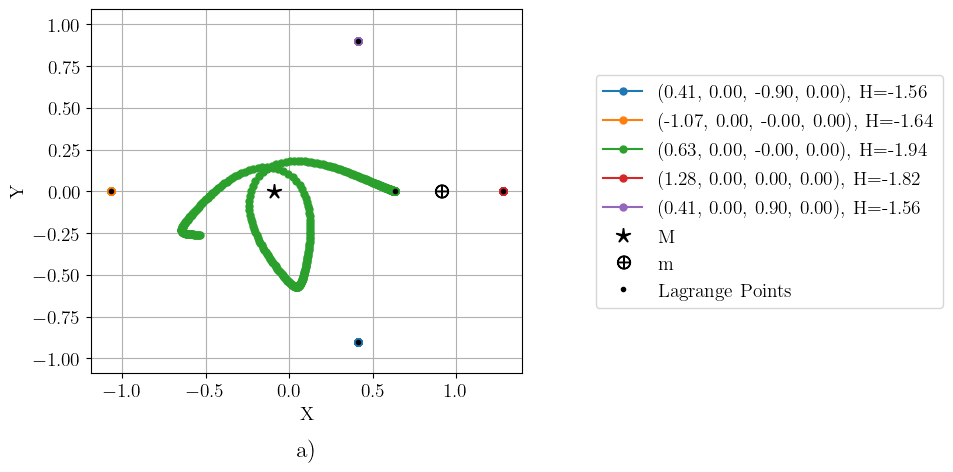

In [ ]:
fig = plt.figure(figsize=(15,5))
axs = [fig.add_subplot(1,1,1)]#,fig.add_subplot(1,3,3, projection='3d')]

initial_conditions = [
    (p[0], 0, p[1], 0) for p in lagrange_points.T
] # X initial, X dot initial, Y initial, Y dot initial

for ic in initial_conditions:
    sol = get_solution(lambda tau, Z: three_body_prob(tau, Z, *args), ic, tstart=0, tend=10, pts=1000, rtol=1e-10, atol=1e-10)
    xa, wa, ya, za = sol.y
    t_eval = sol.t

    line_idxs = t_eval < 20
    traj_h = np.mean(H(xa, wa, ya, za, *args))
    axs[0].plot(xa[line_idxs], ya[line_idxs], label=f"({ic[0]:.2f}, {ic[1]:.2f}, {ic[2]:.2f}, {ic[3]:.2f}), H={traj_h:.2f}", zorder=10, marker='.', markersize=10)

    idxs = []
    chk = -np.abs(ya)
    for i in range(1, len(ya)-1):
        if (chk[i - 1] < chk[i] > chk[i + 1]) and chk[i] > -0.01 and xa[i] > 0:
            idxs.append(i)
    
    # axs[1].scatter(
    #     xa[idxs],
    #     wa[idxs],
    #     za[idxs],
    #     label=f'$X={ic[0]:.2f}, \\dot X={ic[1]:.2f}, Y={ic[2]:.2f}, \\dot Y={ic[3]:.2f}$',
    #     # alpha=0.1
    # )

axs[0].plot(M_pos, 0, label="M", c='black', zorder=10, marker="$\\star$", markersize=10, linestyle='')
axs[0].plot(m_pos, 0, label="m", c='black', zorder=10, marker="$\\oplus$", markersize=10, linestyle='')
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_aspect(1)
axs[0].grid()
bndry = 1.2*m_pos
# axs[1].set_xlim(-bndry, bndry)
axs[0].set_ylim(-bndry, bndry)
axs[0].plot(lagrange_points[0], lagrange_points[1], label='Lagrange Points', c='black', marker=".", linestyle='', zorder=10)
axs[0].legend(loc='center right', bbox_to_anchor=(2, 0.5))

# axs[1].view_init(azim=-45, elev=30)
# axs[1].set_title("b)", y=-0.1)

fig.tight_layout()

plt.savefig("figures/lagrange_point_orbit.pdf")

plt.show()

<lambdifygenerated-13>:2: RuntimeWarning: invalid value encountered in sqrt
  return 1.4142135623731*sqrt(-0.5*_Dummy_134**2 + 0.5*_Dummy_135**2 + 0.5*_Dummy_136**2 + Dummy_137 + 0.707106781186548*d*(0.5*_Dummy_135**2 + 0.5*_Dummy_136**2 + _Dummy_136*f - _Dummy_136 + 0.5*f**2 - f + 0.5)**(-0.5) + 0.707106781186548*e*(0.5*_Dummy_135**2 + 0.5*_Dummy_136**2 + _Dummy_136*f + 0.5*f**2)**(-0.5))


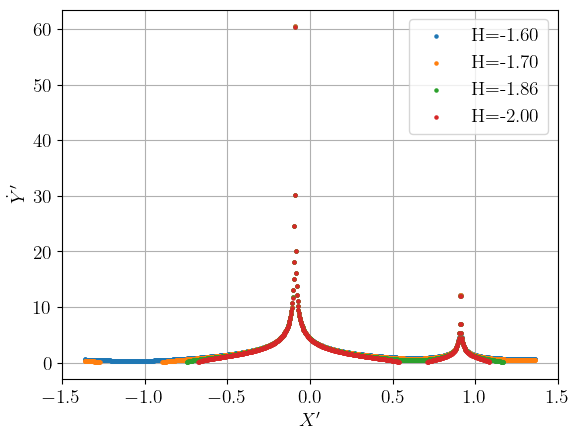

In [64]:
h_prime = Symbol("h^'")
Y_dot_from_h = lambdify([X, X_dot, Y, h_prime, d, e, f], solve(Eq(h_prime, h), Y_dot)[1])

def find_initial_conditions(xstart, xend, pts, H, d, e, f):
    """Assuming that you're on the boundary between the earth and the sun (so X_dot=Y=0), this should find the valid list of X and Y_dot given the 
    nondimensionalized Hamiltonian"""
    initial_conditions=[]
    for X in np.linspace(xstart, xend, pts):
        try:
            yd = Y_dot_from_h(X, 0, 0, H, d, e, f)
            initial_conditions+=[(X, yd)]
        except RuntimeWarning:
            pass
    return np.array(initial_conditions)


ics = []
h_vals = [-1.6, -1.7, -1.86, -2]
for h_val in h_vals:
    ic = find_initial_conditions(-1.5*m_pos, 1.5*m_pos, 1000, h_val, *args)
    ic = ic[~np.isnan(ic).any(axis=1)] # remove nan rows
    ics.append((h_val, ic))
    plt.scatter(ic[:, 0], ic[:, 1], label=f"H={h_val:.2f}", zorder=10, s=5)

plt.legend()
plt.grid(zorder=-1)
plt.xlabel("$X'$")
plt.ylabel("$\dot Y'$")
plt.savefig("figures/hamiltonian_values.pdf")
plt.show()


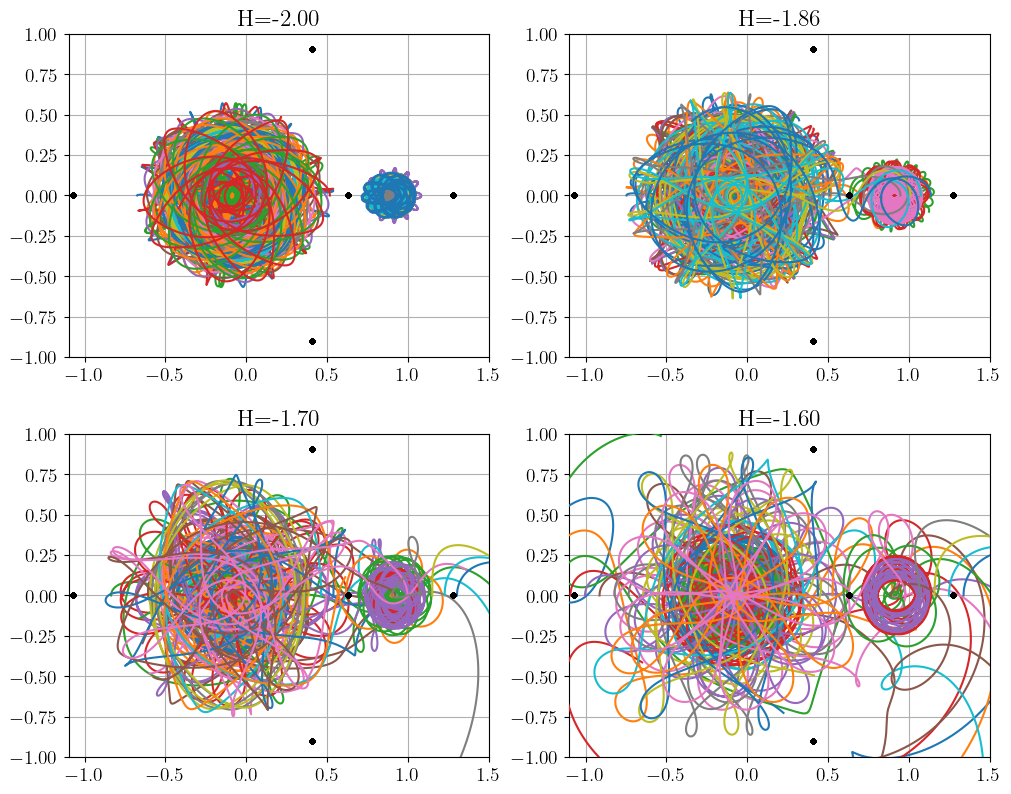

In [63]:
fig, axs = plt.subplots(2,2, figsize=(10,8), layout="constrained")
axs = [item for sublist in axs for item in sublist]

h_acts = []
sols_all = []

for i, (h_des, ic) in enumerate(ics[::-1]):
    chosen_ics = ic[::int(len(ic)/30)]
    h_act = []
    sols = []
    for ic in chosen_ics:
        sol = get_solution(lambda tau, Z: three_body_prob(tau, Z, *args), (ic[0], 0, 0, ic[1]), tstart=0, tend=100, pts=100000, rtol=1e-8, atol=1e-8)
        xa, wa, ya, za = sol.y
        t_eval = sol.t

        line_idxs = t_eval < 15
        h_act.append(H(xa, wa, ya, za, *args))
        axs[i].plot(xa[line_idxs], ya[line_idxs], label=f"({ic[0]:.2f}, {0}, {0}, {ic[1]:.2f})", zorder=10)
        axs[i].set_xlim(-1.1, 1.5)
        axs[i].set_ylim(-1, 1)
        axs[i].set_aspect(1)
        axs[i].set_title(f"H={h_act[0][0]:.2f}")
        axs[i].plot(lagrange_points[0], lagrange_points[1], label='Lagrange Points', c='black', marker=".", linestyle='', zorder=100)
        axs[i].grid(zorder=-10)
        
        sols.append((xa,wa,ya,za,t_eval, h_act[0][0]))
    h_acts.append(h_act)
    sols_all.append(sols)

plt.savefig("figures/hamiltonian_trajectories.pdf")
plt.show()

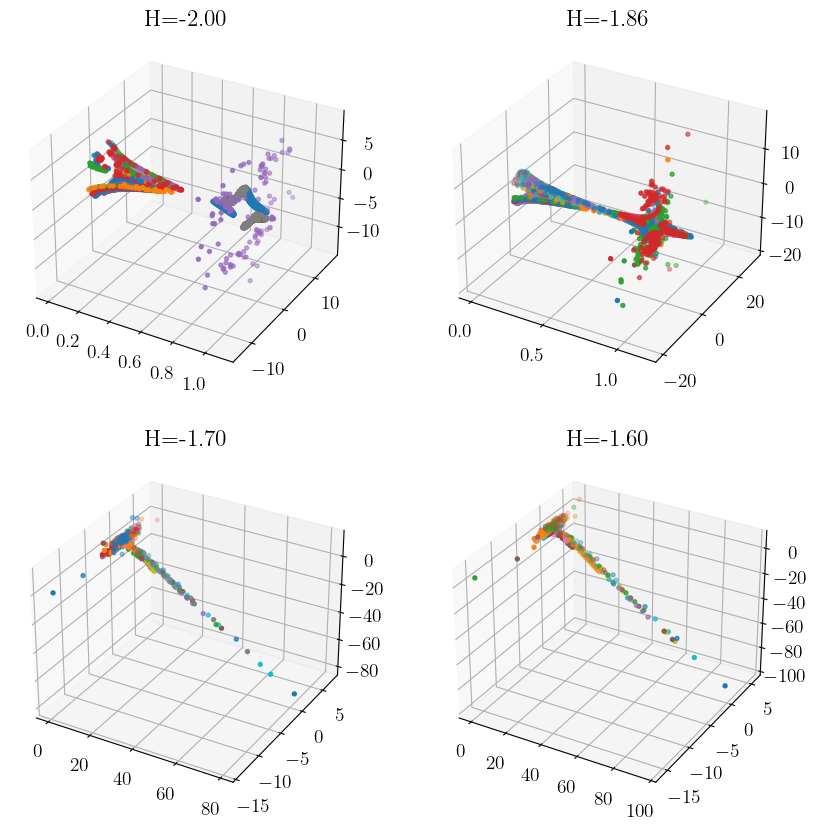

In [65]:
fig = plt.figure(figsize=(10,10))
axs = [fig.add_subplot(2,2,1, projection='3d'), fig.add_subplot(2,2,2, projection='3d'), fig.add_subplot(2,2,3, projection='3d'), fig.add_subplot(2,2,4, projection='3d')]

for idx, sols in enumerate(sols_all):
    for (xa,wa,ya,za,t_eval,h) in sols:
        idxs = []
        chk = -np.abs(ya)
        for i in range(1, len(ya)-1):
            if (chk[i - 1] < chk[i] > chk[i + 1]) and chk[i] > -0.01 and xa[i] > 0:
                idxs.append(i)
        
        axs[idx].scatter(
            xa[idxs],
            wa[idxs],
            za[idxs],
            s=8
            # label=f'$X={ic[0]:.2f}, \\dot X={ic[1]:.2f}, Y={ic[2]:.2f}, \\dot Y={ic[3]:.2f}$',
            # alpha=0.1
        )
    axs[idx].set_title(f"H={h:.2f}")
plt.savefig("figures/hamiltonian_state_space.pdf")